In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
import tensorflow as tf
import os


In [2]:
EMB_PATH = "../../data/embeddings/decision_clf_enh/"
MODEL_NAME = "decision_clf_enh"

MODEL_PATH = f"../models/{MODEL_NAME}/"
K = 5

In [3]:
# loads numpy array of dimensions: X - (num_images, 1280, 1), y - (num_images, num_classes)
files = sorted(os.listdir(EMB_PATH))
X = np.load(f"{EMB_PATH}{files[0]}")  
y = np.load(f"{EMB_PATH}{files[1]}")

# 70-20-10 split of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [4]:
print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (63274, 1280, 1) (63274, 3)
Test set:  (7031, 1280, 1) (7031, 3)


In [5]:
num_classes = y.shape[1]

In [6]:
def k_folds_split(X, y, n=1):
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]
    x_split = np.array_split(X, n)
    y_split = np.array_split(y, n)
    return (x_split, y_split)

In [7]:
def k_folds_join(X, y, ind=0):
    n = len(X)
    train_x, train_y = None, None
    test_x, test_y = X[ind], y[ind]

    for i in range(n):
        if i != ind:
            if type(train_x) != np.ndarray:
                train_x, train_y = X[i], y[i]
            else:
                train_x = np.concatenate((train_x, X[i]))
                train_y = np.concatenate((train_y, y[i]))
    
    return (train_x, train_y), (test_x, test_y)

In [8]:
def kfolds_train(X, y, K):
    results = []
    X_split, y_split = k_folds_split(X, y, K) 

    for i in range(K):
        (X_train, y_train), (X_val, y_val) = k_folds_join(X_split, y_split, i)

        model = Sequential([
            Dense(1024, input_dim=1280, activation='relu'),
            Dense(1024, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(loss='categorical_crossentropy', optimizer='adam', 
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

        model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

        result = model.evaluate(X_test, y_test)
        results.append(result)
    
    return model, results

In [9]:
def train(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=2/9)
    
    model = Sequential([
            Dense(1024, input_dim=1280, activation='relu'),
            Dense(1024, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

    results = model.evaluate(X_test, y_test)
    return model, results

In [10]:
model, results = kfolds_train(X_train, y_train, K)
# model, results = train(X_train, y_train)

Epoch 1/10
396/396 [==============================] - 10s 10ms/step - loss: 0.5928 - accuracy: 0.7395 - precision: 0.7427 - recall: 0.7360 - val_loss: 0.5706 - val_accuracy: 0.7437 - val_precision: 0.7443 - val_recall: 0.7415
Epoch 2/10
396/396 [==============================] - 3s 8ms/step - loss: 0.5570 - accuracy: 0.7515 - precision: 0.7525 - recall: 0.7485 - val_loss: 0.5523 - val_accuracy: 0.7519 - val_precision: 0.7526 - val_recall: 0.7499
Epoch 3/10
396/396 [==============================] - 3s 9ms/step - loss: 0.5457 - accuracy: 0.7576 - precision: 0.7586 - recall: 0.7555 - val_loss: 0.5551 - val_accuracy: 0.7540 - val_precision: 0.7564 - val_recall: 0.7497
Epoch 4/10
396/396 [==============================] - 3s 9ms/step - loss: 0.5372 - accuracy: 0.7612 - precision: 0.7625 - recall: 0.7588 - val_loss: 0.5388 - val_accuracy: 0.7583 - val_precision: 0.7594 - val_recall: 0.7560
Epoch 5/10
396/396 [==============================] - 3s 7ms/step - loss: 0.5317 - accuracy: 0.7626 - 

In [11]:
def display_kfolds_results(results):
    mean_results = [0 for i in range(len(results[0]))]
    for i in range(K):
        for j in range(len(results[i])):
            mean_results[j] += results[i][j]
        print(f"Model {i+1}: {results[i][1]:.4f} (accuracy) {results[i][2]:.4f} (precision) {results[i][3]:.4f} (recall)")

    mean_results = [i/K for i in mean_results]
    print(f"\nMean: {mean_results[1]:.4f} (accuracy) {mean_results[2]:.4f} (precision) {mean_results[3]:.4f} (recall)")

In [12]:
display_kfolds_results(results)

Model 1: 0.7677 (accuracy) 0.7689 (precision) 0.7670 (recall)
Model 2: 0.7675 (accuracy) 0.7678 (precision) 0.7663 (recall)
Model 3: 0.7658 (accuracy) 0.7663 (precision) 0.7648 (recall)
Model 4: 0.7683 (accuracy) 0.7707 (precision) 0.7640 (recall)
Model 5: 0.7468 (accuracy) 0.7469 (precision) 0.7457 (recall)

Mean: 0.7632 (accuracy) 0.7641 (precision) 0.7616 (recall)


In [13]:
probs = model.predict(X_test)
predictions = [np.argmax(i) for i in probs]
labels = [np.argmax(i) for i in y_test]

res = tf.math.confusion_matrix(labels, predictions)

220/220 [==============================] - 1s 3ms/step


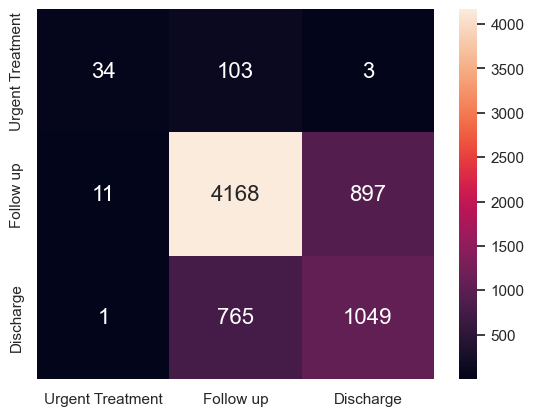

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# classes = sorted(list(set(labels)))
classes = ["Urgent Treatment", "Follow up", "Discharge"]

array = np.array(res).tolist()
df_cm = pd.DataFrame(array, classes, classes)
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()